<a href="https://colab.research.google.com/github/Sultan-manjur/BME/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os                       # OS is for interfacing your own operative system
import pandas as pd             # Pandas is for data analysis and structure manipulation
import matplotlib               # MatPlotLib is for making plots & figures
import matplotlib.pyplot as plt # PyPlot is a subset of the library for making MATLAB-style plots
import h5py
fid = h5py.File(r"dataset_patchcamelyon[1].h5")
X, Y = fid['X'][:], fid['Y'][:]
X = X / 255.
fid.close()
Y=Y.reshape(-1)

In [ ]:
from skimage import color
imgGray = color.rgb2gray(X)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(imgGray,Y,test_size=0.2,shuffle=True, stratify=Y)

In [ ]:
x_train=x_train.reshape(-1,96*96)
x_test=x_test.reshape(-1,96*96)

Text(0, 0.5, 'Completeness Score')

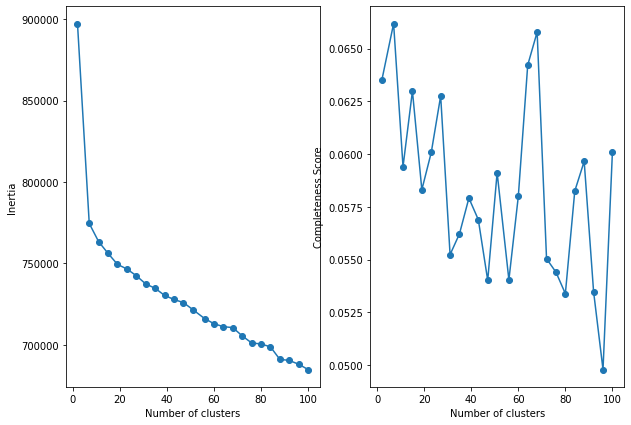

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
import numpy as np

completeness= []
distortion=[]



k=(np.ceil(np.linspace(2,100,25))).astype(int)
# for each number of clusters in the assigned range...
for NCLUS in k:
  
  km_clf = KMeans(n_clusters = NCLUS)
  Y_pred = km_clf.fit_predict(x_train)
  distortion.append(km_clf.inertia_)  
  completeness.append(completeness_score(y_train, Y_pred))

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(k, distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')



plt.subplot(1,2,2)
plt.plot(k, completeness, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Completeness Score')


Text(0, 0.5, 'Completeness Score')

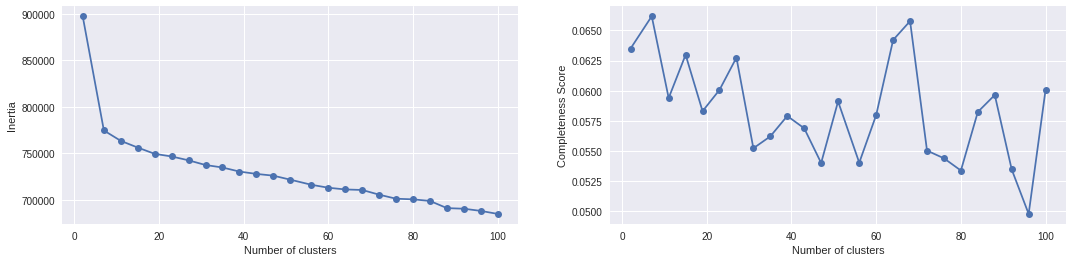

In [ ]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.plot(k, distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')



plt.subplot(1,2,2)
plt.plot(k, completeness, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Completeness Score')

In [ ]:
temp = KMeans(n_clusters = 11)

In [ ]:
xx=temp.fit_transform(x_train)

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly'],
            'gamma':['scale','auto']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [50,100,200],
            'criterion':['entropy','gini']
        }
    },
    'knn':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors':[5,10,15],
            'weights': ['uniform','distance'],
            'p':[1,2]
        }
    },
    'AdaBoost':{
        'model': AdaBoostClassifier(),
        'params':{
            'n_estimators': [50,100,200],
            'learning_rate':[0.5,1,2]
        }
    }


}
scores = []

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(xx,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


,model,best_score,best_params
0,svm,0.7675,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 20}"
1,random_forest,0.7885,"{'n_estimators': 200, 'criterion': 'gini'}"
2,knn,0.7870,"{'weights': 'distance', 'p': 1, 'n_neighbors':..."
3,AdaBoost,0.7760,"{'n_estimators': 200, 'learning_rate': 1}"


In [ ]:
xx_test=temp.transform(x_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf = RandomForestClassifier(n_estimators=200,criterion='gini')
clf.fit(xx,y_train)
y_pred=clf.predict(xx_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       237
           1       0.77      0.84      0.80       263

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500



Text(0.5, 1.0, 'Confusion Matrix')

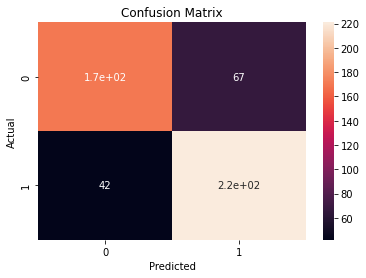

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, np.array(y_pred))
#np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(6,4))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

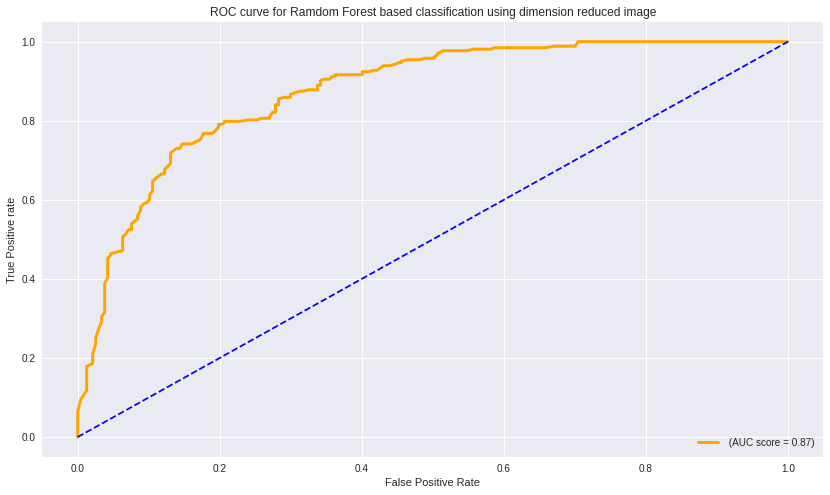

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
y_pred_proba=clf.predict_proba(xx_test)
fpr, tpr, T = roc_curve(y_test,y_pred_proba[:,1])
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr,color='orange', linewidth=3.0, label=r' (AUC score = %0.2f)' % (auc_score) )
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve for Ramdom Forest based classification using dimension reduced image')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()